In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-tachygraphy/Tachygraphy_dataset_main.csv


In [2]:
# To ignore warinings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# DATASET

In [6]:
df=pd.read_csv("/kaggle/input/dataset-tachygraphy/Tachygraphy_dataset_main.csv")
df.shape

(4958, 3)

In [7]:
df.head()

,Text,Meaning,Sentiment
0,Last session of the day http://twitpic.com/67ezh,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely --...,Shanghai is also really exciting (precisely --...,positive
2,submit the report ASAP!,submit the report as soon as possilbe,negative
3,happy bday!,Happy Birthday!,positive
4,The OGs - I like it!!,The original gangsters - i like it!,positive


In [8]:
# df.drop(columns=['Sentiment.1'],inplace=True)

## PREPROCESSING

In [9]:
df=df.drop('Meaning',axis=1)

In [10]:
df.shape

(4958, 2)

In [11]:
df = df.rename(columns={'Text': 'tweet'})

In [12]:
df = df.rename(columns={'Sentiment': 'class'})

In [13]:
df['class'] = df['class'].str.lower()
sentiment_counts = df['class'].value_counts()
sentiment_counts

class
neutral     1743
positive    1643
negative    1572
Name: count, dtype: int64

In [14]:
df = df[df['class'] != "neutral"]  ###droping neutral columns

In [15]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['class'])
encoded_labels = label_encoder.transform(df['class'])
df['class'] = encoded_labels

In [16]:
df.head()

,tweet,class
1,Shanghai is also really exciting (precisely --...,1
2,submit the report ASAP!,0
3,happy bday!,1
4,The OGs - I like it!!,1
5,that`s great!! weee!! visitors!,1


In [17]:
df.isnull().sum()

tweet    1
class    0
dtype: int64

In [18]:
df=df.fillna('')

In [19]:
df.head()

,tweet,class
1,Shanghai is also really exciting (precisely --...,1
2,submit the report ASAP!,0
3,happy bday!,1
4,The OGs - I like it!!,1
5,that`s great!! weee!! visitors!,1


In [20]:
import re
from bs4 import BeautifulSoup

def text_cleaning(text):
    text = str(text)
    soup = BeautifulSoup(text, "html.parser")    ###removing html tages
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())      ##removing text within square brackets
    pattern = r"[^a-zA-Z0-9\s,']"                  # Removing unwanted characters
    text = re.sub(pattern, '', text)
    url_pattern = r'http\S+|www\S+'            ###removing urls
    text = re.sub(url_pattern, '', text)
    return text

In [21]:
df['tweet'] = df['tweet'].apply(text_cleaning).tolist()

In [22]:
df.head(10)

,tweet,class
1,Shanghai is also really exciting precisely sk...,1
2,submit the report ASAP,0
3,happy bday,1
4,The OGs I like it,1
5,thats great weee visitors,1
6,I THINK EVERYONE HATES ME ON HERE lol,0
7,"soooooo wish i could, but im in school and mys...",0
10,My bike was put on holdshould have known that ...,0
13,"Im in VA for the weekend, my youngest son turn...",0
14,Its coming out the socket I feel like my phone...,0


In [23]:
lens=[len(i.split()) for i in df['tweet']]

(array([135., 493., 641., 585., 429., 438., 237., 174.,  74.,   9.]),
 array([ 0. ,  3.2,  6.4,  9.6, 12.8, 16. , 19.2, 22.4, 25.6, 28.8, 32. ]),
 <BarContainer object of 10 artists>)

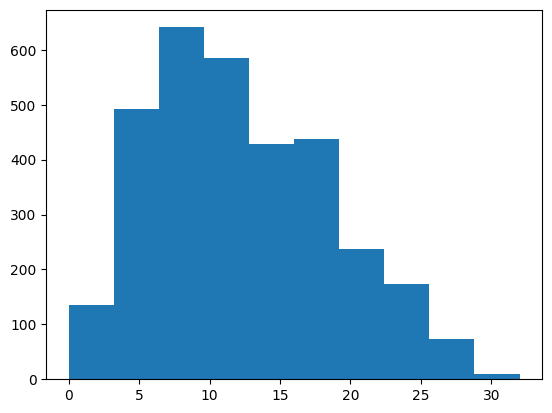

In [24]:
import matplotlib.pyplot as plt
plt.hist(lens)

In [25]:
import torch
import torch.nn as nn

import transformers
from transformers import AutoModel, BertTokenizerFast, AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoModel, AdamW, get_linear_schedule_with_warmup

In [26]:
# split into train, validation and test sets in the ration 70 : 15 : 15
from sklearn.model_selection import train_test_split

train_text, temp_text, train_labels, temp_labels = train_test_split(df['tweet'], df['class'], 
                                                                    random_state=2021, 
                                                                    test_size=0.2, 
                                                                    stratify=df['class'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2021, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [27]:
bert = AutoModel.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [28]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(array([192., 469., 502., 424., 315., 268., 194., 145.,  55.,   8.]),
 array([ 1. ,  4.1,  7.2, 10.3, 13.4, 16.5, 19.6, 22.7, 25.8, 28.9, 32. ]),
 <BarContainer object of 10 artists>)

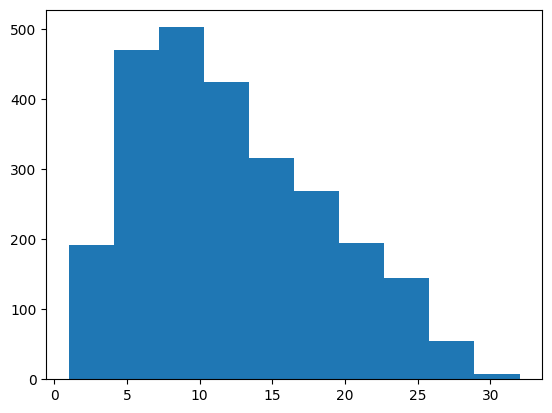

In [29]:
train_lens=[len(i.split()) for i in train_text]
plt.hist(train_lens)

In [30]:
import pandas as pd

sequence_lengths = df['tweet'].apply(lambda x: len(x.split()))
print(sequence_lengths.describe())


count    3215.000000
mean       12.223328
std         6.223879
min         0.000000
25%         7.000000
50%        11.000000
75%        17.000000
max        32.000000
Name: tweet, dtype: float64


In [31]:
pad_len = 128

## ENCODING

In [32]:
# tokenizing and encoding sequences 
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    add_special_tokens=True,
    truncation=True,
    return_token_type_ids=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    add_special_tokens=True,
    truncation=True,
    return_token_type_ids=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    add_special_tokens=True,
    truncation=True,
    return_token_type_ids=True
)

In [33]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_token_type_ids = torch.tensor(tokens_train["token_type_ids"])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_token_type_ids = torch.tensor(tokens_val["token_type_ids"])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_token_type_ids = torch.tensor(tokens_test["token_type_ids"])
test_y = torch.tensor(test_labels.tolist())

In [34]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 64  ##batch size can be adjusted or modified
train_data = TensorDataset(train_seq, train_mask, train_token_type_ids, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_data = TensorDataset(val_seq, val_mask, val_token_type_ids, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [35]:
# for param in bert.parameters():
#     param.requires_grad = False

In [36]:
for name, param in bert.named_parameters():
    if "layer.11" in name or "layer.10" in name:  # Fine-tune last two layers
        param.requires_grad = True
    else:
        param.requires_grad = False

# MODEL

In [37]:
import torch.nn as nn

##model building
class SentimentClassifier(nn.Module):
     
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
            token_type_ids=token_type_ids
        ) 
        output = self.drop(pooled_output)  ##drop out layer
        return self.out(output)

    
class BERT_architecture(nn.Module):

    def __init__(self, bert):
        super(BERT_architecture, self).__init__()
        self.bert = bert
        
        self.dropout = nn.Dropout(0.3)  # Increased dropout for regularization
        self.layer_norm = nn.LayerNorm(768)  # Layer normalization
        
        self.fc1 = nn.Linear(768, 256)  # Dense layer
        self.fc2 = nn.Linear(256, 2)  # Output layer with 2 classes
        
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask, token_type_ids):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        x = self.layer_norm(cls_hs)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [38]:
model = BERT_architecture(bert)

In [39]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
test_token_type_ids = test_token_type_ids.to(device)
model.to(device)

BERT_architecture(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [40]:
from transformers import AdamW
# optimizer = AdamW(model.parameters(),lr = 1e-3)  ## learning rate needs to be adjusted.
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8, weight_decay=0.01)

In [41]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn

# Compute the class weights for three classes
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(train_labels),
                                     y=train_labels)
print("Class weights are {} for {}".format(class_weights, np.unique(train_labels)))

Class weights are [1.02225755 0.97869102] for [0 1]


In [42]:
pd.value_counts(train_labels)

class
1    1314
0    1258
Name: count, dtype: int64

In [43]:
# weights = torch.tensor(class_weights, dtype=torch.float)

# weights = weights.to(device)
# cross_entropy = nn.CrossEntropyLoss()

epochs = 12 ##increase the no of epochs for better accuracy 


## HYPERPARAMS SETUP

In [44]:
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Loss function
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
cross_entropy = nn.CrossEntropyLoss(weight=weights)

In [45]:
from torch.cuda.amp import GradScaler, autocast

## EARLY STOPPING SETUP

In [46]:
class EarlyStopping:
    def __init__(self, patience, delta=0):  # Increased patience
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, valid_loss):
        if valid_loss < self.best_loss - self.delta:
            self.best_loss = valid_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [47]:
early_stopping = EarlyStopping(patience=3)

In [48]:
# Gradient Scaler
scaler = GradScaler()

## FUNCTIONS

In [49]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds, total_labels = [], []

    for step, batch in enumerate(train_dataloader, 0):
        batch = [r.to(device) for r in batch]
        sent_id, mask, token_type_ids, labels = batch

        optimizer.zero_grad()

        with autocast():
            preds = model(sent_id, mask, token_type_ids)
            loss = cross_entropy(preds, labels)
        
        # Accumulate the loss
        total_loss += loss.item()

        # Perform backward pass with mixed precision
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        total_labels.append(labels.detach().cpu().numpy())

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)
    return avg_loss, total_preds, total_labels

In [50]:
# def train():
#     model.train()
#     total_loss, total_accuracy = 0, 0
#     total_preds, total_labels = [], []

#     for step, batch in enumerate(train_dataloader, 0):
#         batch = [r.to(device) for r in batch]
#         sent_id, mask, token_type_ids, labels = batch

#         model.zero_grad()
#         preds = model(sent_id, mask, token_type_ids)
#         loss = cross_entropy(preds, labels)
#         total_loss = total_loss + loss.item()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         optimizer.step()
#         scheduler.step()

#         preds = preds.detach().cpu().numpy()
#         total_preds.append(preds)
#         total_labels.append(labels.detach().cpu().numpy())

#     avg_loss = total_loss / len(train_dataloader)
#     total_preds = np.concatenate(total_preds, axis=0)
#     total_labels = np.concatenate(total_labels, axis=0)
#     return avg_loss, total_preds, total_labels

In [51]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0, 0
    total_preds, total_labels = [], []

    for step, batch in enumerate(val_dataloader):
        batch = [t.to(device) for t in batch]
        sent_id, mask, token_type_ids, labels = batch

        with torch.no_grad(), autocast():
            preds = model(sent_id, mask, token_type_ids)
            loss = cross_entropy(preds, labels)
        
        total_loss += loss.item()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        total_labels.append(labels.detach().cpu().numpy())

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)
    return avg_loss, total_preds, total_labels

In [52]:
# def evaluate():
#     model.eval()
#     total_loss, total_accuracy = 0, 0
#     total_preds, total_labels = [], []

#     for step, batch in enumerate(val_dataloader):
#         batch = [t.to(device) for t in batch]
#         sent_id, mask, token_type_ids, labels = batch

#         with torch.no_grad():
#             preds = model(sent_id, mask, token_type_ids)
#             loss = cross_entropy(preds, labels)
#             total_loss = total_loss + loss.item()
#             preds = preds.detach().cpu().numpy()
#             total_preds.append(preds)
#             total_labels.append(labels.detach().cpu().numpy())

#     avg_loss = total_loss / len(val_dataloader)
#     total_preds = np.concatenate(total_preds, axis=0)
#     total_labels = np.concatenate(total_labels, axis=0)
#     return avg_loss, total_preds, total_labels


In [53]:
def calculate_accuracy(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    accuracy = np.sum(preds_flat == labels_flat) / len(labels_flat)
    return accuracy

In [54]:
# def train():
#     model.train()
#     total_loss, total_accuracy = 0, 0
#     total_preds, total_labels = [], []

#     for step, batch in enumerate(train_dataloader, 0):
#         if step % 50 == 0 and not step == 0:
#             print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

# #         sent_id = batch[:,0].to(device, dtype = torch.long)
# #         mask = data[:,1].to(device, dtype = torch.long)
# #         token_type_ids = data[:,2].to(device, dtype = torch.long)
# #         labels = data[:,3].to(device, dtype = torch.float)
        
# #         token_type_ids = batch['token_type_ids'].to(device)
#         batch = [r.to(device) for r in batch]
#         sent_id, mask, token_type_ids, labels = batch

#         model.zero_grad()
#         preds = model(sent_id, mask, token_type_ids)
#         loss = cross_entropy(preds, labels)
#         total_loss = total_loss + loss.item()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         optimizer.step()

#         preds = preds.detach().cpu().numpy()
#         total_preds.append(preds)
#         total_labels.append(labels.detach().cpu().numpy())

#     avg_loss = total_loss / len(train_dataloader)
#     total_preds = np.concatenate(total_preds, axis=0)
#     total_labels = np.concatenate(total_labels, axis=0)
#     return avg_loss, total_preds, total_labels

# def evaluate():
#     print("\nEvaluating after the test: ")
#     model.eval()
#     total_loss, total_accuracy = 0, 0
#     total_preds, total_labels = [], []

#     for step, batch in enumerate(val_dataloader):
#         if step % 50 == 0 and not step == 0:
#             print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
            
# #         sent_id = batch[:,0].to(device, dtype = torch.long)
# #         mask = data[:,1].to(device, dtype = torch.long)
# #         token_type_ids = data[:,2].to(device, dtype = torch.long)
# #         labels = data[:,3].to(device, dtype = torch.float)

# #         token_type_ids = batch['token_type_ids'].to(device)
#         batch = [t.to(device) for t in batch]
#         sent_id, mask, token_type_ids, labels = batch

#         with torch.no_grad():
#             preds = model(sent_id, mask, token_type_ids)
#             loss = cross_entropy(preds, labels)
#             total_loss = total_loss + loss.item()
#             preds = preds.detach().cpu().numpy()
#             total_preds.append(preds)
#             total_labels.append(labels.detach().cpu().numpy())

#     avg_loss = total_loss / len(val_dataloader)
#     total_preds = np.concatenate(total_preds, axis=0)
#     total_labels = np.concatenate(total_labels, axis=0)
#     return avg_loss, total_preds, total_labels

# def calculate_accuracy(preds, labels):

#     preds_flat = np.argmax(preds, axis=1).flatten()
#     labels_flat = labels.flatten()
#     accuracy = np.sum(preds_flat == labels_flat) / len(labels_flat)
#     return accuracy


In [55]:
# best_valid_loss = float('inf')
# train_losses = []
# valid_losses = []
# train_accuracies = []
# valid_accuracies = []

# for epoch in range(epochs):
#     print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
#     train_loss, train_preds, train_labels = train()
#     valid_loss, valid_preds, valid_labels = evaluate()
#     train_accuracy = calculate_accuracy(train_preds, train_labels)
#     valid_accuracy = calculate_accuracy(valid_preds, valid_labels)

#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'saved_weights.pt')
    
#     train_losses.append(train_loss)
#     valid_losses.append(valid_loss)
#     train_accuracies.append(train_accuracy)
#     valid_accuracies.append(valid_accuracy)
    
#     print('\nTraining Loss: {}'.format(train_loss))
#     print('Validation Loss: {}'.format(valid_loss))
#     print('Training Accuracy: {:.2f}%'.format(train_accuracy * 100))
#     print('Validation Accuracy: {:.2f}%'.format(valid_accuracy * 100))


In [56]:
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []


for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    train_loss, train_preds, train_labels = train()
    valid_loss, valid_preds, valid_labels = evaluate()
    train_accuracy = calculate_accuracy(train_preds, train_labels)
    valid_accuracy = calculate_accuracy(valid_preds, valid_labels)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    early_stopping(valid_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break
    
    print('\nTraining Loss: {}'.format(train_loss))
    print('Validation Loss: {}'.format(valid_loss))
    print('Training Accuracy: {:.2f}%'.format(train_accuracy * 100))
    print('Validation Accuracy: {:.2f}%'.format(valid_accuracy * 100))


 Epoch 1 / 12

Training Loss: 0.6766260062775961
Validation Loss: 0.6399853030840555
Training Accuracy: 57.35%
Validation Accuracy: 66.67%

 Epoch 2 / 12

Training Loss: 0.631024536563129
Validation Loss: 0.5665971984465917
Training Accuracy: 65.24%
Validation Accuracy: 68.54%

 Epoch 3 / 12

Training Loss: 0.5722531218354295
Validation Loss: 0.5188212891419729
Training Accuracy: 72.01%
Validation Accuracy: 71.96%

 Epoch 4 / 12

Training Loss: 0.5186550748057481
Validation Loss: 0.49283300836881
Training Accuracy: 75.58%
Validation Accuracy: 75.39%

 Epoch 5 / 12

Training Loss: 0.47623760816527577
Validation Loss: 0.44695616513490677
Training Accuracy: 78.15%
Validation Accuracy: 77.57%

 Epoch 6 / 12

Training Loss: 0.44290938246540906
Validation Loss: 0.4215400417645772
Training Accuracy: 79.90%
Validation Accuracy: 78.82%

 Epoch 7 / 12

Training Loss: 0.42149487937368996
Validation Loss: 0.41073910892009735
Training Accuracy: 81.61%
Validation Accuracy: 80.37%

 Epoch 8 / 12

Tr

# CLASSIFICATION REPORT

In [57]:
from sklearn.metrics import classification_report
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device), test_token_type_ids.to(device))
  preds = preds.detach().cpu().numpy()
pred = np.argmax(preds, axis = 1)
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       157
           1       0.80      0.81      0.81       165

    accuracy                           0.80       322
   macro avg       0.80      0.80      0.80       322
weighted avg       0.80      0.80      0.80       322



In [58]:
def predict_user_input(input_text, model, tokenizer, device):
    inputs = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        max_length=max_seq_len,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors='pt',
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask, token_type_ids)
        preds = torch.argmax(outputs, dim=1)
    
    return preds.item()
max_seq_len=128
input_text = "I been told you that yo folks dont care about you . Im starving and my dad deadass didnt make me a plate"
predicted_class = predict_user_input(input_text, model, tokenizer, device)
if(predicted_class==0):
    print('Predicted sentiment: Negative')
else:
    print('Predicted sentiment: Positive')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Predicted sentiment: Negative


In [59]:
input_text = "what a badass character Arthur is, rckstr is the bst"
predicted_class = predict_user_input(input_text, model, tokenizer, device)
if(predicted_class==0):
    print('Predicted sentiment: Negative')
else:
    print('Predicted sentiment: Positive')

Predicted sentiment: Positive
